# README

This File is used to Train a NER model to identify location Entities from a raw location string.

The Enities I am concerned with are Countries, Cities, states, and if remote is mentioned which in the production code will be a bolean. 

The Goal of this model is to be able to parse a raw location string into the named entities in the raw location string. 

Distilled Bert LLM from hugging face is used as the base model that I fine tuned with my own data. 

I used label studio to label the entities and then wrote code to parse the export from label studio into the format that the bert llm is expecting.

I use the `seqeval` package for model metrics and evaluation. 

The models in this notebook were trained on my personal computer using Linux to enable GPU usage on my Nvidia 2080 super GPU.

# Imports

In [7]:
import torch
from transformers import DataCollatorWithPadding, DistilBertTokenizer, pipeline, \
                    DistilBertForSequenceClassification, TrainingArguments, Trainer, \
                    DistilBertTokenizerFast, DistilBertForTokenClassification, AutoModelForTokenClassification, TrainerCallback

from torch.utils.data.dataloader import default_collate
from datasets import Dataset
import numpy as np
import pandas as pd
import math
from pynvml import *
from functools import partial
import evaluate
accuracy = evaluate.load("accuracy")
from sklearn.metrics import confusion_matrix
from accelerate import Accelerator
accelerator = Accelerator()
import gc
import matplotlib.pyplot as plt
import seaborn as sn
from IPython.display import clear_output

import contractions
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re
stop_words = set(stopwords.words('english'))
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from seqeval.scheme import IOB2
import json
import os

[nltk_data] Downloading package stopwords to /home/connor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Sanity Check 
print(os.getcwd())

/home/connor/Documents/jobs/jobs/Location_Model


# EDA Location Data 

## EDA Functions 

In [9]:
def preprocess_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

## Create Data Set For label Studio

In [12]:
df = pd.read_csv('./location_data/all_data.csv')
df.drop(axis=1, inplace=True, columns=['id'])
df

,title,description,raw_location
0,"Vice President, Software Engineering",Xometry (NASDAQ: XMTR) powers the industries o...,"North Bethesda, MD, Lexington, KY, Remote"
1,VP of Product,"Hi! Its SplitMetrics, a remote-first team of e...",Remote - United Kingdom
2,VP of Product,"Hi! Its SplitMetrics, a remote-first team of e...",Remote
3,"Vice President, Engineering","At Airwallex (airwallex.com), were building th...",US - San Francisco
4,VP Engineering,About Us We believe AI will fundamentally tran...,"Remote, USA"
...,...,...,...
5318,Front End Web Developer Intern (Buenos Aires-R...,We are looking for programmers with a keen eye...,NaN
5319,Android Internship In Endevor IT Solutions,Company Description Bestowed with high profess...,"Indore, MP, in"
5320,Business Analyst Intern (Buenos Aires -Remote),Token Metrics is searching for a highly capabl...,NaN
5321,Graduate Automation Engineer,Graduate Engineer- AutomationWe have a great o...,Australia – New South Wales


In [13]:
new_df = df.dropna(subset=['raw_location'])

In [14]:
new_df['fmt_raw_location'] = new_df['raw_location'].apply(lambda x: preprocess_text(x))
new_df

/tmp/ipykernel_6043/3299897354.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['fmt_raw_location'] = new_df['raw_location'].apply(lambda x: preprocess_text(x))


,title,description,raw_location,fmt_raw_location
0,"Vice President, Software Engineering",Xometry (NASDAQ: XMTR) powers the industries o...,"North Bethesda, MD, Lexington, KY, Remote","north bethesda, md, lexington, ky, remote"
1,VP of Product,"Hi! Its SplitMetrics, a remote-first team of e...",Remote - United Kingdom,remote - united kingdom
2,VP of Product,"Hi! Its SplitMetrics, a remote-first team of e...",Remote,remote
3,"Vice President, Engineering","At Airwallex (airwallex.com), were building th...",US - San Francisco,us - san francisco
4,VP Engineering,About Us We believe AI will fundamentally tran...,"Remote, USA","remote, usa"
...,...,...,...,...
5316,Crypto QA Automation Engineer Intern (Sao Paul...,Token Metrics is looking for an experienced QA...,São Paulo,são paulo
5317,Crypto Engineering Manager Intern (Bucharest-R...,We are looking for a trustworthy and proactive...,Bucharest,bucharest
5319,Android Internship In Endevor IT Solutions,Company Description Bestowed with high profess...,"Indore, MP, in","indore, mp, in"
5321,Graduate Automation Engineer,Graduate Engineer- AutomationWe have a great o...,Australia – New South Wales,australia – new south wales


In [222]:
new_df.to_csv('./location_data/all_data_fmt_location.csv', index=False, header=True)

In [15]:
df = pd.read_csv('./location_data/all_data_fmt_location.csv')
df.drop(axis=1, inplace=True, columns=['id'])
df

,title,description,raw_location,fmt_raw_location
0,"Vice President, Software Engineering",Xometry (NASDAQ: XMTR) powers the industries o...,"North Bethesda, MD, Lexington, KY, Remote","north bethesda, md, lexington, ky, remote"
1,VP of Product,"Hi! Its SplitMetrics, a remote-first team of e...",Remote - United Kingdom,remote - united kingdom
2,VP of Product,"Hi! Its SplitMetrics, a remote-first team of e...",Remote,remote
3,"Vice President, Engineering","At Airwallex (airwallex.com), were building th...",US - San Francisco,us - san francisco
4,VP Engineering,About Us We believe AI will fundamentally tran...,"Remote, USA","remote, usa"
...,...,...,...,...
5213,Crypto QA Automation Engineer Intern (Sao Paul...,Token Metrics is looking for an experienced QA...,São Paulo,são paulo
5214,Crypto Engineering Manager Intern (Bucharest-R...,We are looking for a trustworthy and proactive...,Bucharest,bucharest
5215,Android Internship In Endevor IT Solutions,Company Description Bestowed with high profess...,"Indore, MP, in","indore, mp, in"
5216,Graduate Automation Engineer,Graduate Engineer- AutomationWe have a great o...,Australia – New South Wales,australia – new south wales


# Model Train

## Load Label Studio Export Data

In [370]:
df = pd.read_json('./location_data/label_studio_data/label-studio-export_v2.json')
df['label'] = df['label'].apply(lambda x: [] if x is np.nan else x)# Replace nans with an empty list 
df

,id,title,description,raw_location,fmt_raw_location,label,annotator,annotation_id,created_at,updated_at,lead_time
0,4155,"Vice President, Software Engineering",Xometry (NASDAQ: XMTR) powers the industries o...,"North Bethesda, MD, Lexington, KY, Remote","north bethesda, md, lexington, ky, remote","[{'start': 16, 'end': 18, 'text': 'md', 'label...",2,62,2024-04-09 21:34:21.146053+00:00,2024-04-09 21:34:21.146086+00:00,14.943
1,4156,VP of Product,"Hi! Its SplitMetrics, a remote-first team of e...",Remote - United Kingdom,remote - united kingdom,"[{'start': 9, 'end': 23, 'text': 'united kingd...",2,63,2024-04-09 21:34:34.088538+00:00,2024-04-09 21:34:34.088571+00:00,10.999
2,4157,VP of Product,"Hi! Its SplitMetrics, a remote-first team of e...",Remote,remote,"[{'start': 0, 'end': 6, 'text': 'remote', 'lab...",2,64,2024-04-09 21:34:39.463909+00:00,2024-04-09 21:34:39.463942+00:00,3.831
3,4158,"Vice President, Engineering","At Airwallex (airwallex.com), were building th...",US - San Francisco,us - san francisco,"[{'start': 5, 'end': 18, 'text': 'san francisc...",2,65,2024-04-09 21:34:49.208866+00:00,2024-04-09 21:34:49.208903+00:00,6.598
4,4159,VP Engineering,About Us We believe AI will fundamentally tran...,"Remote, USA","remote, usa","[{'start': 8, 'end': 11, 'text': 'usa', 'label...",2,66,2024-04-09 21:34:58.376343+00:00,2024-04-09 21:34:58.376374+00:00,6.864
...,...,...,...,...,...,...,...,...,...,...,...
205,4907,Associate director - Network Infrastructure Ar...,"Who We AreAt Kyndryl, we design, build, manage...","Noisy-Le-Grand, Seine-Saint-Denis, France","noisy-le-grand, seine-saint-denis, france","[{'start': 35, 'end': 41, 'text': 'france', 'l...",2,268,2024-04-25 01:52:29.365282+00:00,2024-04-25 01:52:29.365315+00:00,21.611
206,4908,Associate Design Director (UX/UI),Insomniac Design is a global digital agency he...,"Chisinau, Moldova","chisinau, moldova","[{'start': 10, 'end': 17, 'text': 'moldova', '...",2,267,2024-04-25 01:52:02.340580+00:00,2024-04-25 01:52:02.340614+00:00,13.097
207,4912,"Associate Director~Manager, JPBU DD&T, Data Ma...","By clicking the Apply button, I understand tha...","Tokyo, Japan","tokyo, japan","[{'start': 0, 'end': 5, 'text': 'tokyo', 'labe...",2,269,2024-04-25 01:54:09.179651+00:00,2024-04-25 01:54:09.179674+00:00,4.760
208,4916,Director of Product Management,"At SmartBear, we deliver the complete visibili...","Somerville, Massachusetts, United States","somerville, massachusetts, united states","[{'start': 0, 'end': 10, 'text': 'somerville',...",2,270,2024-04-25 01:55:41.515428+00:00,2024-04-25 01:55:41.515447+00:00,87.735


In [371]:
df.iloc[0]['label']

[{'start': 16, 'end': 18, 'text': 'md', 'labels': ['state']},
 {'start': 31, 'end': 33, 'text': 'ky', 'labels': ['state']},
 {'start': 35, 'end': 41, 'text': 'remote', 'labels': ['remote']},
 {'start': 0, 'end': 14, 'text': 'north bethesda', 'labels': ['city']},
 {'start': 20, 'end': 29, 'text': 'lexington', 'labels': ['city']}]

## NER Helper Functions

In [ ]:
def create_ner_label_mappings(token_labels):
    """Create IOB entity labels for each label"""
    label2id = {'O': 0}
    id2label = {0: 'O'}
    index = 1  
    for label in token_labels:
        for prefix in ['B-', 'I-']:
            current_label = f"{prefix}{label.upper()}"
            label2id[current_label] = index
            id2label[index] = current_label
            index += 1
    print(f"Num Labels: {len(label2id.keys())}")
    print(f"label2id: {label2id}")
    print(f"id2label: {id2label}")
    return label2id, id2label

def format_rows_for_ner_train(df):
    """Create Train and test rows renaming columns to the correct names"""
    final_df = df[['fmt_raw_location','label']].copy()
    final_df.rename(columns = {'fmt_raw_location':'text'}, inplace = True) 
    
    training_rows_DS = Dataset.from_pandas(final_df)
    training_rows_DS = training_rows_DS.train_test_split(train_size=.8, seed=42) 

    train_rows = pd.DataFrame(list(zip(training_rows_DS['train']['text'], training_rows_DS['train']['label'])), columns =['text','label'])
    test_rows = pd.DataFrame(list(zip(training_rows_DS['test']['text'], training_rows_DS['test']['label'])), columns =['text','label'])
    
    return training_rows_DS, train_rows, test_rows

def align_label(tokenized_inputs, label_list):
    """Applies IOB labeling technique to token lists"""
    if isinstance(tokenized_inputs['input_ids'], torch.Tensor):
        label_length = tokenized_inputs['input_ids'].size()[1]
    else:
        label_length = len(tokenized_inputs['input_ids'])
    
    example_labels = ['O'] * label_length # Initialize all tokens as 'O'

    if isinstance(tokenized_inputs['offset_mapping'], torch.Tensor):
        offset_mapping_list = tokenized_inputs['offset_mapping'][0] 
        offset_mapping_len  = offset_mapping_list.size()[0]  
    else:
        offset_mapping_list = tokenized_inputs['offset_mapping']
        offset_mapping_len  = len(offset_mapping_list)
        
    for label in label_list:
        label_start = label['start']
        label_end = label['end']
        label_type = label['labels'][0]

        # Assign B- and I- labels
        for idx, (start, end) in enumerate(offset_mapping_list):
            if idx == 0 or idx == offset_mapping_len - 1 or start == end:
                continue
            if start >= label_start and end <= label_end:
                if start == label_start:
                    example_labels[idx] = f"B-{label_type.upper()}"
                else:
                    example_labels[idx] = f"I-{label_type.upper()}"

    return example_labels

def align_labels_with_tokens_batched(batch, tokenizer, label2id, tokenizer_config, **kwargs):
    """Applies IOB labeling technique to token lists from a batch of examples"""
    batch_input_ids, batch_attention_mask, batch_labels = [], [], []

    for i in range(len(batch['text'])):
        tokenized_inputs = tokenizer(batch['text'][i], **tokenizer_config)
        example_labels = align_label(tokenized_inputs, label_list = batch['label'][i])

        # Add tokenized inputs and labels for this example to the batch
        batch_input_ids.append(tokenized_inputs['input_ids'])
        batch_attention_mask.append(tokenized_inputs['attention_mask'])

        # label_ids = [label2id[label] for label in example_labels] # Old way where cls and sep were labeled as 0. New way is below. 
        
        # Convert labels to numerical IDs; label special tokens and padding as -100
        last_real_token_index = len(tokenized_inputs['attention_mask']) - 1 - tokenized_inputs['attention_mask'][::-1].index(1)    
        label_ids = [
            -100 if i == 0 or i == last_real_token_index or tokenized_inputs['attention_mask'][i] == 0 else label2id.get(label, label2id['O'])
            for i, label in enumerate(example_labels)
        ]
        
        batch_labels.append(label_ids)  # Convert labels to numerical IDs
        
        # Remove offset_mapping  
        tokenized_inputs.pop('offset_mapping', None)

    return {
        'input_ids': batch_input_ids,
        'attention_mask': batch_attention_mask,
        'labels': batch_labels
    }
    
def align_labels_with_tokens_single(example, tokenizer, label2id, tokenizer_config, **kwargs):
    """
    Function to align labels with tokens for a single example. Can handle returning pts from tokenizer or standard lists. 
    """
    tokenized_inputs = tokenizer(example['text'], **tokenizer_config)
    example_labels = align_label(tokenized_inputs, label_list = example['label'])
    # Remove offsets mapping 
    tokenized_inputs.pop("offset_mapping", None)
    # tokenized_inputs['labels'] = [label2id[label] for label in example_labels] # Old way where cls and sep were labeled as 0. New way is below. 

    # Convert labels to numerical IDs; label special tokens and padding as -100
    if isinstance(tokenized_inputs['attention_mask'], torch.Tensor):
        attention_mask_list = tokenized_inputs['attention_mask'][0].tolist()            
    else:
        attention_mask_list = tokenized_inputs['attention_mask']
        
    last_real_token_index = len(attention_mask_list) - 1 - attention_mask_list[::-1].index(1)
    tokenized_inputs['labels'] = [
        -100 if i == 0 or i == last_real_token_index or attention_mask_list[i] == 0 else label2id.get(label, label2id['O'])
        for i, label in enumerate(example_labels)
    ]
    return tokenized_inputs

def custom_data_collator(features):
    """
    Custom data collator that bypasses tokenization and padding.
    Assumes that all preprocessing, including tokenization and padding, has been handled.
    """
    for feature in features:
        for key, value in feature.items():
            if isinstance(value, list):
                feature[key] = torch.tensor(value)
    return default_collate(features)

def compute_metrics_token_classification(pred):
    """Computes precision recall and f1 score using seqeval package"""
    predictions = np.argmax(pred.predictions, axis=2)
    true_labels = pred.label_ids

    pred_labels = [[id2label[p] for (p, l) in zip(prediction, true_label) if l != -100] for prediction, true_label in zip(predictions, true_labels)]
    true_labels = [[id2label[l] for (p, l) in zip(prediction, true_label) if l != -100] for prediction, true_label in zip(predictions, true_labels)]   

    
    return {
        "precision": precision_score(true_labels, pred_labels),
        "recall": recall_score(true_labels, pred_labels),
        "f1": f1_score(true_labels, pred_labels)
    }

def eval_model(model_trainer, test_rows_DS, id2label):
    """Creates eval graph using the same compute metrics used in model training."""
    predictions_output = model_trainer.predict(test_rows_DS)
    predictions = predictions_output.predictions
    label_ids = predictions_output.label_ids
    
    predicted_label_ids = np.argmax(predictions, axis=2)
    
    pred_labels = [[id2label[p] for (p, l) in zip(prediction, true_label) if l != -100] for prediction, true_label in zip(predicted_label_ids, label_ids)]
    true_labels = [[id2label[l] for l in true_label if l != -100] for true_label in label_ids]
    
    report_dict = classification_report(true_labels, pred_labels, mode='strict', scheme=IOB2, output_dict=True)
    visualize_report(report_dict)


def autolabel(rects, ax):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        

def visualize_report(report_dict):
    """Creates a visual report showing the metric scores per entity"""
    entities = [entity for entity in report_dict.keys() if entity not in ['macro avg', 'weighted avg', 'micro avg']]
    precisions = [report_dict[entity]['precision'] for entity in entities]
    recalls = [report_dict[entity]['recall'] for entity in entities]
    f1_scores = [report_dict[entity]['f1-score'] for entity in entities]
    
    x = np.arange(len(entities))  # the label locations
    
    fig, ax = plt.subplots(figsize=(10, 8))
    width = 0.3  # the width of the bars
    
    rects1 = ax.bar(x - width/2, precisions, width, label='Precision')
    rects2 = ax.bar(x + width/2, recalls, width, label='Recall')
    rects3 = ax.bar(x + 1.5*width, f1_scores, width, label='F1-score')
    
    ax.set_ylabel('Scores')
    ax.set_title('Scores by entity')
    ax.set_xticks(x)
    ax.set_xticklabels(entities, rotation=45)
    ax.legend()
    
    autolabel(rects1, ax)
    autolabel(rects2, ax)
    autolabel(rects3, ax)
    
    fig.tight_layout()
    plt.show()

## Model Function

In [374]:
def run_model_v10(train_rows, test_rows, preprocess_funct_batched, tokenizer, tokenizer_config, 
                  num_epochs, train_batch_size, test_batch_size, base_model, out_put_dir, compute_metrics, id2label, should_return=False):
    """ 
    Convenience Function used to train and evaluate a model given train and test set.
    Saves the model at finish. 
    """
    train_rows_DS = Dataset.from_pandas(train_rows)
    test_rows_DS = Dataset.from_pandas(test_rows)
        
    train_rows_DS = train_rows_DS.map(preprocess_funct_batched, 
                                      batched=True, remove_columns=["text", "label"])
    test_rows_DS = test_rows_DS.map(preprocess_funct_batched, 
                                    batched=True, remove_columns=["text", "label"])
    
    base_model = accelerator.prepare(base_model)
    
    training_args = TrainingArguments(
        output_dir=out_put_dir,
        overwrite_output_dir=True, 
        num_train_epochs=num_epochs, 
        per_device_train_batch_size=train_batch_size, 
        per_device_eval_batch_size=test_batch_size,  
        load_best_model_at_end=True,
        logging_steps=5,
        log_level='info',
        evaluation_strategy='epoch',
        save_strategy='epoch'
    )

    trainer = Trainer(
        model=base_model,
        args=training_args,
        train_dataset=train_rows_DS,
        eval_dataset=test_rows_DS,
        data_collator=custom_data_collator,
        compute_metrics=compute_metrics_token_classification,
    )
    
    
    train_results = trainer.train()    
    eval_model(trainer, test_rows_DS, id2label)    
    trainer.save_model()

## Setup Data for model train

In [375]:
training_rows_DS, train_rows, test_rows = format_rows_for_ner_train(df)

## Model Config

In [376]:
max_length=256
out_put_dir = "./location_bert_v2"
tokenizer_out_put_dir = out_put_dir+"_tokenizer"
tokenizer_config = {'max_length': max_length,
                    'truncation': True,
                    'padding': 'max_length',
                    'is_split_into_words': False
                   }
token_labels = ['city', 'state', 'country', 'remote']
label2id, id2label = create_ner_label_mappings(token_labels)

train_batch = 4
test_batch = 4
epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Num Labels: 9
label2id: {'O': 0, 'B-CITY': 1, 'I-CITY': 2, 'B-STATE': 3, 'I-STATE': 4, 'B-COUNTRY': 5, 'I-COUNTRY': 6, 'B-REMOTE': 7, 'I-REMOTE': 8}
id2label: {0: 'O', 1: 'B-CITY', 2: 'I-CITY', 3: 'B-STATE', 4: 'I-STATE', 5: 'B-COUNTRY', 6: 'I-COUNTRY', 7: 'B-REMOTE', 8: 'I-REMOTE'}
Device: cuda


## Load and Save Tokenizer Config

In [25]:
tokenizer_funct = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer_funct.save_pretrained(tokenizer_out_put_dir)
with open(tokenizer_out_put_dir+"/tokenizer_config.json", "w") as f:
    json.dump(tokenizer_config, f)

/home/connor/anaconda3/envs/job_exp/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Base Model Load

In [377]:
base_model = DistilBertForTokenClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(id2label.keys()), id2label=id2label, label2id=label2id
)
base_model.to(device)

loading file vocab.txt from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/vocab.txt
loading file tokenizer.json from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/tokenizer_config.json
loading configuration file config.json from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout":

DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

## Model Training 

### V1 

Map: 100%|██████████| 24/24 [00:00<00:00, 2717.10 examples/s]
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/home/connor/anaconda3/envs/py3_10/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
***** Running training *****
  Num examples = 92
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total 

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.995700,0.505171,0.755102,0.840909,0.795699
2,0.269200,0.229483,0.931818,0.931818,0.931818
3,0.076300,0.155862,0.954545,0.954545,0.954545
4,0.038600,0.172622,0.931818,0.931818,0.931818
5,0.075500,0.162194,0.931818,0.931818,0.931818


***** Running Evaluation *****
  Num examples = 24
  Batch size = 4
Saving model checkpoint to ./location_bert/checkpoint-23
Configuration saved in ./location_bert/checkpoint-23/config.json
Model weights saved in ./location_bert/checkpoint-23/model.safetensors
***** Running Evaluation *****
  Num examples = 24
  Batch size = 4
Saving model checkpoint to ./location_bert/checkpoint-46
Configuration saved in ./location_bert/checkpoint-46/config.json
Model weights saved in ./location_bert/checkpoint-46/model.safetensors
***** Running Evaluation *****
  Num examples = 24
  Batch size = 4
Saving model checkpoint to ./location_bert/checkpoint-69
Configuration saved in ./location_bert/checkpoint-69/config.json
Model weights saved in ./location_bert/checkpoint-69/model.safetensors
***** Running Evaluation *****
  Num examples = 24
  Batch size = 4
Saving model checkpoint to ./location_bert/checkpoint-92
Configuration saved in ./location_bert/checkpoint-92/config.json
Model weights saved in ./lo

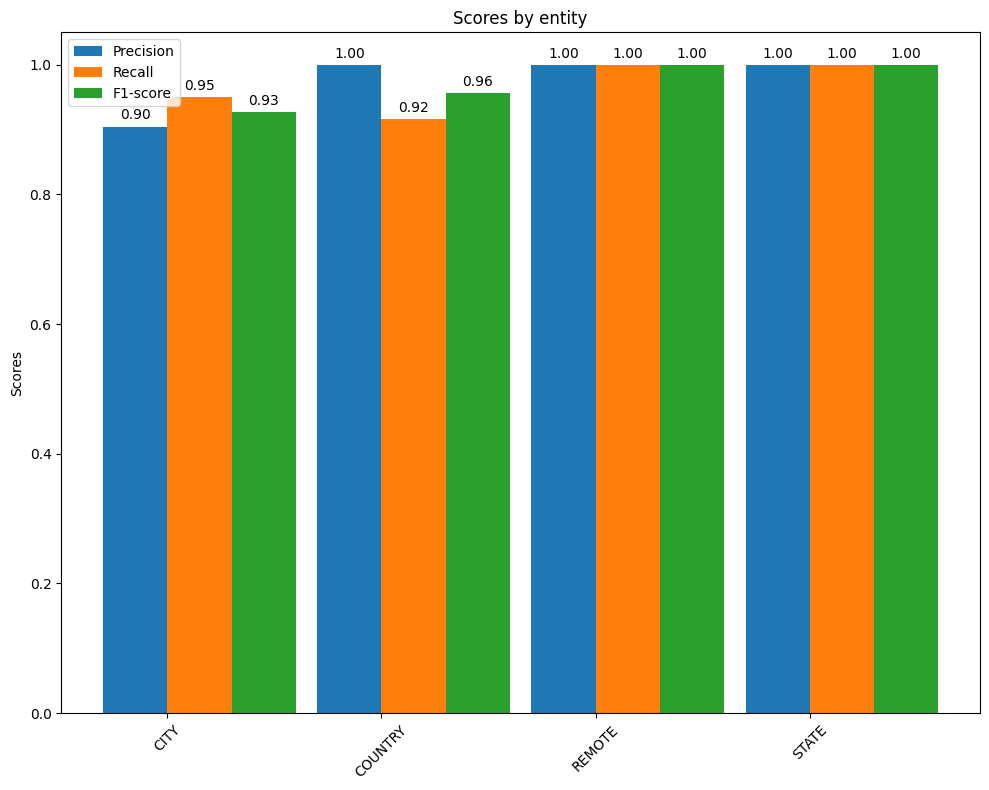

Saving model checkpoint to ./location_bert
Configuration saved in ./location_bert/config.json
Model weights saved in ./location_bert/model.safetensors


In [284]:
# Add the correct agurements to align_labels_with_tokens_batched function 
preprocess_funct_batched = partial(align_labels_with_tokens_batched, tokenizer=tokenizer_funct, label2id=label2id, tokenizer_config=tokenizer_config)
# Train the model 
run_model_v10(train_rows, test_rows, preprocess_funct_batched, tokenizer_funct, tokenizer_config, epochs, train_batch, test_batch, base_model, out_put_dir, compute_metrics_token_classification, id2label, True)
del base_model

### V2

Map: 100%|██████████| 42/42 [00:00<00:00, 2928.40 examples/s]
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/home/connor/anaconda3/envs/py3_10/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
***** Running training *****
  Num examples = 168
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.433200,0.316979,0.746269,0.769231,0.757576
2,0.104400,0.210175,0.892308,0.892308,0.892308
3,0.089200,0.169355,0.921875,0.907692,0.914729
4,0.060600,0.133970,0.907692,0.907692,0.907692
5,0.009300,0.142334,0.923077,0.923077,0.923077


***** Running Evaluation *****
  Num examples = 42
  Batch size = 4
Saving model checkpoint to ./location_bert_v2/checkpoint-42
Configuration saved in ./location_bert_v2/checkpoint-42/config.json
Model weights saved in ./location_bert_v2/checkpoint-42/model.safetensors
***** Running Evaluation *****
  Num examples = 42
  Batch size = 4
Saving model checkpoint to ./location_bert_v2/checkpoint-84
Configuration saved in ./location_bert_v2/checkpoint-84/config.json
Model weights saved in ./location_bert_v2/checkpoint-84/model.safetensors
***** Running Evaluation *****
  Num examples = 42
  Batch size = 4
Saving model checkpoint to ./location_bert_v2/checkpoint-126
Configuration saved in ./location_bert_v2/checkpoint-126/config.json
Model weights saved in ./location_bert_v2/checkpoint-126/model.safetensors
***** Running Evaluation *****
  Num examples = 42
  Batch size = 4
Saving model checkpoint to ./location_bert_v2/checkpoint-168
Configuration saved in ./location_bert_v2/checkpoint-168/c

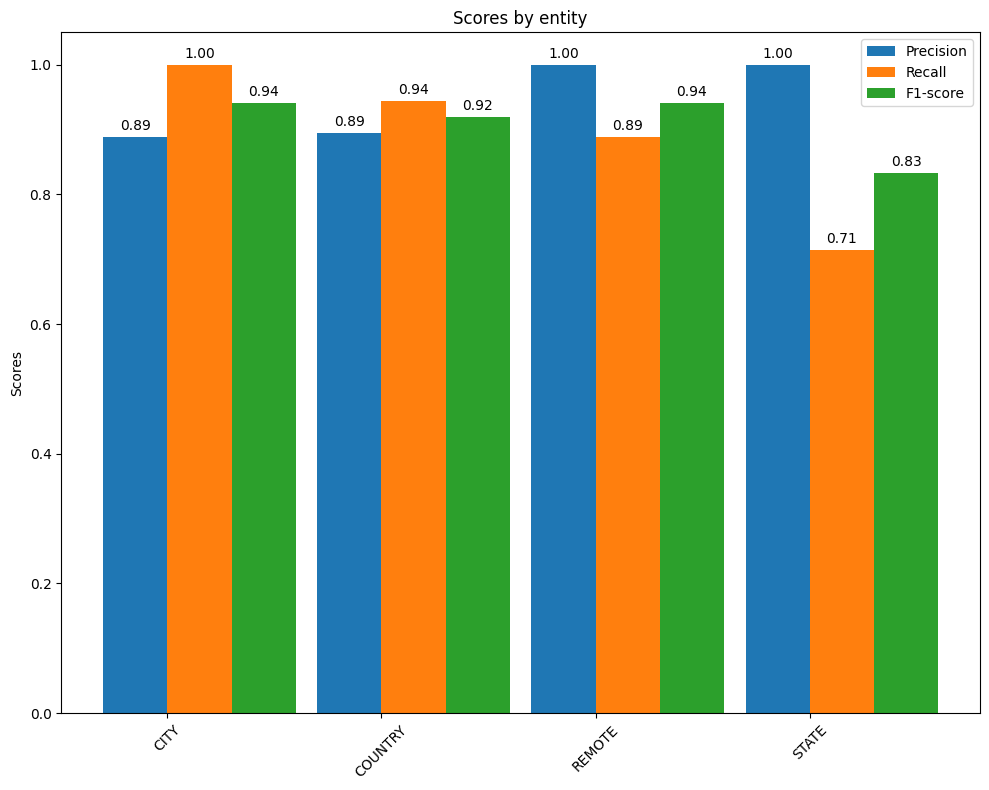

Saving model checkpoint to ./location_bert_v2
Configuration saved in ./location_bert_v2/config.json
Model weights saved in ./location_bert_v2/model.safetensors


In [378]:
# Add the correct agurements to align_labels_with_tokens_batched function 
preprocess_funct_batched = partial(align_labels_with_tokens_batched, tokenizer=tokenizer_funct, label2id=label2id, tokenizer_config=tokenizer_config)
# Train the model 
run_model_v10(train_rows, test_rows, preprocess_funct_batched, tokenizer_funct, tokenizer_config, epochs, train_batch, test_batch, base_model, out_put_dir, compute_metrics_token_classification, id2label, True)
del base_model

#### Conclusion
For the current task this is an acceptable model given that I only hand labeled 200 examples. 

In future iterations with more labeled data I theorize better results. 

# Model Eval

## Load Existing Model

In [285]:
token_classifier = AutoModelForTokenClassification.from_pretrained(out_put_dir)
token_classifier.to(device)
tokenizer_funct = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

loading configuration file ./location_bert/config.json
Model config DistilBertConfig {
  "_name_or_path": "./location_bert",
  "activation": "gelu",
  "architectures": [
    "DistilBertForTokenClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "O",
    "1": "B-CITY",
    "2": "I-CITY",
    "3": "B-STATE",
    "4": "I-STATE",
    "5": "B-COUNTRY",
    "6": "I-COUNTRY",
    "7": "B-REMOTE",
    "8": "I-REMOTE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "B-CITY": 1,
    "B-COUNTRY": 5,
    "B-REMOTE": 7,
    "B-STATE": 3,
    "I-CITY": 2,
    "I-COUNTRY": 6,
    "I-REMOTE": 8,
    "I-STATE": 4,
    "O": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.39.1",
  "voc

## Eval Functions

In [ ]:
def eval_ner_example(example_inputs, classifier):
    """Evaluate a single example through ner model"""
    with torch.no_grad():
        outputs = classifier(**example_inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    return predictions

def make_predictions(input_example, token_classifier, tokenizer, id2label):
    """
    Makes a prediction on a tokenized input. Where predicted token 
    ids are converted back to entity names
    """
    # move input_tensors onto Device
    inputs = {k: v.to(device) for k, v in input_example.items()} 
    # Make prediction
    result = eval_ner_example(inputs, token_classifier) # returns a tensor
    # Move prediction back to cpu
    predictions_np = result.cpu().numpy() # returns a nparray
    # Move attention_mask back to cpu
    attention_mask_np = input_example['attention_mask'].cpu().numpy()# returns a nparray
    # Replace the 1s in the attention mask with the actual returned prediction. replace the 0s with -100
    adjusted_predictions = np.where(attention_mask_np == 1, predictions_np, -100) 
    flat_predictions = adjusted_predictions.flatten() # remove the extra dimension  
    
    attention_mask_flat = attention_mask_np.flatten() # remove extra dimension on np array
    attention_mask_list = attention_mask_flat.tolist() # convert nparray to list 
    last_real_token_index = len(attention_mask_list) - 1 - attention_mask_list[::-1].index(1) # grab the index of the last real item
    filtered_predictions_ids = flat_predictions[:last_real_token_index+1] # use last index +1 to remove the -100s
    
    pred_label_names = [id2label[id] for id in filtered_predictions_ids] # Convert Ids to labels 
    inputs = {k: v.to('cpu') for k, v in inputs.items()} 
    input_ids_list = inputs['input_ids'].squeeze().tolist()  # Remove extra dimension and convert tensor to list  
    # Grab the tokens for the input example then conver them from ids to actual string token. then Remove the pad tokens. 
    tokens = tokenizer.convert_ids_to_tokens(input_ids_list) 
    tokens = [token for token in tokens if token != '[PAD]']
    
    del inputs # Free up memory  
    return pred_label_names, tokens, last_real_token_index
    
def eval_example_with_true_label(example, token_classifier, tokenizer, tokenizer_config, label2id, id2label, device):
    """
    Makes a prediction on a given example.  An example is sent through full pipeline where it is tokenized. 
    Where predicted token ids are converted back to entity names. True label is also printed out with prediction
    """
    input_example = align_labels_with_tokens_single(example, tokenizer=tokenizer, label2id=label2id, tokenizer_config={'return_tensors':"pt", **tokenizer_config})
    true_label_ids = input_example.pop('labels') # the true labels for an example

    pred_label_names, tokens, last_real_token_index = make_predictions(input_example, token_classifier, tokenizer, id2label)
    
    # Grab the actual label name from the true labels
    true_label_names = [-100 if id == -100 else id2label[id] for id in true_label_ids[:last_real_token_index+1]] # Convert Ids to labels
    
    print(f"Raw Location: \n{example['text']}\n")
    print(f"{'Pred':<15}{'True':<15}{'Token':<10}")
    for pred, actual, token in zip(pred_label_names, true_label_names, tokens):
        print(f"{pred:<15}{actual:<15}{token:<10}")
    
    # Free up memory 
    if device == 'cuda':
        torch.cuda.empty_cache() 
    
    return {
        'predicted_labels': pred_label_names, 
        'actual_labels': true_label_names, 
        'tokens': tokens,
        'raw_string': example['text']
    }

def eval_example_no_label(example, token_classifier, tokenizer, tokenizer_config, label2id, id2label, device):
    """
    Makes a prediction on a given example. An example is sent through full pipeline where it is tokenized. 
    Where predicted token ids are converted back to entity names. 
    """
    input_example = tokenizer_funct(example, return_tensors="pt", **tokenizer_config)
    input_example.pop("offset_mapping", None)

    pred_label_names, tokens, _ = make_predictions(input_example, token_classifier, tokenizer, id2label)
        
    print(f"Raw Location: \n{example}\n")
    print(f"{'Pred':<15}{'Token':<10}")
    for pred, token in zip(pred_label_names, tokens):
        print(f"{pred:<15}{token:<10}")
    
    # Free up memory  
    if device == 'cuda':
        torch.cuda.empty_cache() 
    
    return {
        'predicted_labels': pred_label_names, 
        'tokens': tokens,
        'raw_string': example
    }


def check_test_preds_extract(df, token_classifier, tokenizer_funct, tokenizer_config, label2id, id2label, device):
    """
    Examples looped over and predictions are made on them. 
    Output is printed to the screen where the user can use keys to iterate over predictions.
    """
    should_break_loop = False
    for row_count, row in df.iterrows():
        obj_no_label = eval_example_no_label(row['text'], token_classifier, tokenizer_funct, tokenizer_config, label2id, id2label, device)
        print(build_final_dict(obj_no_label['tokens'], obj_no_label['predicted_labels']))
        while True:
            print()
            user_input = input(" F to continue. P Escape")
            user_input = user_input.lower() 
            if user_input in ['f','p']:
                if user_input == 'p':
                    should_break_loop = True
                    break
                elif user_input == 'f': 
                    break

        clear_output()
        if should_break_loop :
            break

def build_final_dict(tokens, pred_labels):
    """
    Takes the tokens and predicted token labels and rebuilds tokens into strings 
    creates the country, state, city, and remote lists
    """
    entities = {
        "country": [],
        "state": [],
        "city": [],
        "remote": False 
    }
    
    current_entity_tokens = []
    current_entity_label = None
    
    for token, pred_token_label in zip(tokens, pred_labels):
        # Skip special tokens
        if token in ['[CLS]', '[SEP]']:
            continue
        
        if pred_token_label == 'B-REMOTE':  # Check for remote first
            entities['remote'] = True
            continue  
        
        if pred_token_label != 'O':  # Not an outside word
            prefix, entity = pred_token_label.split('-')
            if prefix == 'B':  # Start of a new entity
                # Save current entity if there is one
                if current_entity_label and current_entity_tokens:
                    entities[current_entity_label].append(''.join(current_entity_tokens))
                
                # Start a new entity
                current_entity_tokens = [token.replace('##', '')]  # Remove BPE marker for subwords
                current_entity_label = entity.lower()  # Start a new entity label
            elif prefix == 'I' and entity.lower() == current_entity_label and current_entity_tokens:
                # Continue the current entity
                if token.startswith('##'):
                    current_entity_tokens.append(token.replace('##', ''))
                else:
                    current_entity_tokens.append(' ' + token)  # Add space if it's a full word
        else:
            # Save the entity if we hit an 'O' and we have an ongoing entity
            if current_entity_label and current_entity_tokens:
                entities[current_entity_label].append(''.join(current_entity_tokens))
                current_entity_tokens = []
                current_entity_label = None
    
    # Capture any entity that goes right up to the end without hitting an 'O'
    if current_entity_label and current_entity_tokens:
        entities[current_entity_label].append(''.join(current_entity_tokens))
    
    return {
        "country_list": entities['country'], 
        "state_list": entities['state'],
        "city_list": entities['city'],
        "remote": entities['remote']
    }

### Testing Eval Functions

In [292]:
example = test_rows.iloc[3]
# example = new_df.iloc[0]['fmt_raw_location']
example

text             north bethesda, md, lexington, ky, remote
label    [{'end': 18, 'labels': ['state'], 'start': 16,...
Name: 3, dtype: object

In [144]:
obj_w_label = eval_example_with_true_label(example, token_classifier, tokenizer_funct, tokenizer_config, label2id, id2label, device)
print()
obj_no_label = eval_example_no_label(example['text'], token_classifier, tokenizer_funct, tokenizer_config, label2id, id2label, device)

Raw Location: 
us - san francisco

Pred           True           Token     
O              -100           [CLS]     
B-COUNTRY      B-COUNTRY      us        
O              O              -         
B-CITY         B-CITY         san       
I-CITY         I-CITY         francisco 
I-REMOTE       -100           [SEP]     

Raw Location: 
us - san francisco

Pred           Token     
O              [CLS]     
B-COUNTRY      us        
O              -         
B-CITY         san       
I-CITY         francisco 
I-REMOTE       [SEP]     


In [311]:
build_final_dict(obj_no_label['tokens'], obj_no_label['predicted_labels'])

{'country_list': [],
 'state_list': ['md', 'ky'],
 'city_list': ['bethesda', 'lexington'],
 'remote': True}

In [310]:
check_test_preds_extract(test_rows, token_classifier, tokenizer_funct, tokenizer_config, label2id, id2label, device)

## Eval Class 
Class example created here for future use in production setting. 
This is the first iteration of a model class to be used.

In [323]:
class LocationParser():
    def __init__(self, config): 
        self.device = config['device']
        self.token_classifier = AutoModelForTokenClassification.from_pretrained(config['out_put_dir'])
        self.token_classifier.to(self.device)
        self.tokenizer_funct = DistilBertTokenizerFast.from_pretrained(config['tokenizer'])
        self.id2label = config['id2label']
        self.label2id = config['label2id']
        self.tokenizer_config = config['tokenizer_config_eval']


    def predict(self, input):
        """Makes actual prediction"""
        with torch.no_grad():
            outputs = self.token_classifier(**input)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        return predictions

    def make_predictions(self, tokenized_input):
        """Makes prediction and returns predicted label names and input tokens"""
        # move input_tensors onto Device
        inputs = {k: v.to(self.device) for k, v in tokenized_input.items()} 
        # Make prediction
        result = self.predict(inputs) # returns a tensor
        # Move prediction back to cpu
        predictions_np = result.cpu().numpy() # returns a nparray
        # Move attention_mask back to cpu
        attention_mask_np = tokenized_input['attention_mask'].cpu().numpy()# returns a nparray

        # Replace the 1s in the attention mask with the actual returned prediction. replace the 0s with -100
        adjusted_predictions = np.where(attention_mask_np == 1, predictions_np, -100) 
        flat_predictions = adjusted_predictions.flatten() # remove the extra dimension  
        attention_mask_flat = attention_mask_np.flatten() # remove extra dimension on np array
        attention_mask_list = attention_mask_flat.tolist() # convert nparray to list 

        last_real_token_index = len(attention_mask_list) - 1 - attention_mask_list[::-1].index(1) # grab the index of the last real item
        filtered_predictions_ids = flat_predictions[:last_real_token_index+1] # use last index +1 to remove the -100s
        
        predicted_token_labels = [self.id2label[id] for id in filtered_predictions_ids] # Convert Ids to labels 
        inputs = {k: v.to('cpu') for k, v in inputs.items()} 
        input_ids_list = inputs['input_ids'].squeeze().tolist()  # Remove extra dimension and convert tensor to list  

        # Grab the tokens for the input example then conver them from ids to actual string token. then Remove the pad tokens. 
        tokens = self.tokenizer_funct.convert_ids_to_tokens(input_ids_list) 
        tokens = [token for token in tokens if token != '[PAD]']
        
        del inputs # Free up memory  
        return predicted_token_labels, tokens
    
    def preprocess_text(self, text):
        """
        Preprocesses the text
        """
        text = text.lower()
        text = contractions.fix(text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
        
    def get_entities(self, raw_text):
        """Pipeline function that preprocesses, tokenizes, makes the prediction and then outputs the final dictionary of entities"""
        fmt_text = self.preprocess_text(raw_text)# preprocess text
        
        tokenized_input = self.tokenizer_funct(fmt_text, **self.tokenizer_config) # tokenize text
        tokenized_input.pop("offset_mapping", None)

        predicted_token_labels, tokens = self.make_predictions(tokenized_input) # make token prediction

        ############ Test Code 
        # print(f"Raw Location: \n{raw_text}\n")
        # print(f"{'Pred':<15}{'Token':<10}")
        # for pred, token in zip(predicted_token_labels, tokens):
        #     print(f"{pred:<15}{token:<10}")
        ############
    
        # Free up memory  
        if self.device == 'cuda':
            torch.cuda.empty_cache() 
        
        result = self.build_final_dict(tokens, predicted_token_labels)
        return result
    

    def build_final_dict(self, tokens, pred_labels):
        """
        Takes the tokens and predicted token labels and rebuilds tokens into strings 
        creates the country, state, city, and remote lists
        """
        entities = {
            "country": [],
            "state": [],
            "city": [],
            "remote": False 
        }
        
        current_entity_tokens = []
        current_entity_label = None
        
        for token, pred_token_label in zip(tokens, pred_labels):
            if token in ['[CLS]', '[SEP]']: # Skip special tokens
                continue

            if pred_token_label == 'B-REMOTE':  # Check for remote first
                entities['remote'] = True
                continue  
            
            if pred_token_label != 'O':  # Not an outside word
                prefix, entity = pred_token_label.split('-')
                if prefix == 'B':  # Start of a new entity
                    # Save current entity if there is one
                    if current_entity_label and current_entity_tokens:
                        entities[current_entity_label].append(''.join(current_entity_tokens))
                    
                    # Start a new entity
                    current_entity_tokens = [token.replace('##', '')]  # Remove BPE marker for subwords
                    current_entity_label = entity.lower()  # Start a new entity label
                elif prefix == 'I' and entity.lower() == current_entity_label and current_entity_tokens:
                    # Continue the current entity
                    if token.startswith('##'):
                        current_entity_tokens.append(token.replace('##', ''))
                    else:
                        current_entity_tokens.append(' ' + token)  # Add space if it's a full word
            else:
                # Save the entity if we hit an 'O' and we have an ongoing entity
                if current_entity_label and current_entity_tokens:
                    entities[current_entity_label].append(''.join(current_entity_tokens))
                    current_entity_tokens = []
                    current_entity_label = None
        
        # Capture any entity that goes right up to the end without hitting an 'O'
        if current_entity_label and current_entity_tokens:
            entities[current_entity_label].append(''.join(current_entity_tokens))
        
        return {
            "country_list": entities['country'], 
            "state_list": entities['state'],
            "city_list": entities['city'],
            "remote": entities['remote']
        }        

In [379]:
config={}
config['out_put_dir'] = f"./location_bert_v2"
config['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config['max_length'] = 256
config['tokenizer'] = 'distilbert-base-uncased'
config['tokenizer_config_eval'] = {'max_length': config['max_length'],
                    'truncation': True,
                    'padding': 'max_length',
                    'return_offsets_mapping':True,
                    'return_tensors':"pt"
                   }
config['id2label'] = {0: 'O', 1: 'B-CITY', 2: 'I-CITY', 3: 'B-STATE', 4: 'I-STATE', 5: 'B-COUNTRY', 6: 'I-COUNTRY', 7: 'B-REMOTE', 8: 'I-REMOTE'}
config['label2id'] = {'O': 0, 'B-CITY': 1, 'I-CITY': 2, 'B-STATE': 3, 'I-STATE': 4, 'B-COUNTRY': 5, 'I-COUNTRY': 6, 'B-REMOTE': 7, 'I-REMOTE': 8}


LP = LocationParser(config)

loading configuration file ./location_bert_v2/config.json
Model config DistilBertConfig {
  "_name_or_path": "./location_bert_v2",
  "activation": "gelu",
  "architectures": [
    "DistilBertForTokenClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "O",
    "1": "B-CITY",
    "2": "I-CITY",
    "3": "B-STATE",
    "4": "I-STATE",
    "5": "B-COUNTRY",
    "6": "I-COUNTRY",
    "7": "B-REMOTE",
    "8": "I-REMOTE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "B-CITY": 1,
    "B-COUNTRY": 5,
    "B-REMOTE": 7,
    "B-STATE": 3,
    "I-CITY": 2,
    "I-COUNTRY": 6,
    "I-REMOTE": 8,
    "I-STATE": 4,
    "O": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.39.1",


In [321]:
df = pd.read_csv('./location_data/all_data_fmt_location.csv')

In [380]:
LP.get_entities(text)

{'country_list': ['india'],
 'state_list': [],
 'city_list': ['chennai'],
 'remote': False}

In [385]:
# Code that brings up a window for user to iterate over data to see how the model is doing.  
for _, row in df.iterrows():
    
    text = row['raw_location']
    print(text)
    print(LP.get_entities(text))
    should_break_loop = False
    while True:
        print()
        user_input = input(" F to continue. P Escape")
        user_input = user_input.lower() 
        if user_input in ['f','p']:
            if user_input == 'p':
                should_break_loop = True
                break
            elif user_input == 'f': 
                break

    clear_output()
    if should_break_loop :
        break

In [386]:
del LP